<a href="https://colab.research.google.com/github/pengyk/COMP551/blob/main/Copy_of_Copy_of_mini_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import math
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cases_df = pd.read_csv("drive/My Drive/COMP551/assignment1/aggregated_cc_by.csv")
trends_df = pd.read_csv("drive/My Drive/COMP551/assignment1//2020_US_weekly_symptoms_dataset.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
trends_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,symptom:Amblyopia,symptom:Amenorrhea,symptom:Amnesia,symptom:Anal fissure,symptom:Anaphylaxis,symptom:Anemia,symptom:Angina pectoris,symptom:Angioedema,symptom:Angular cheilitis,symptom:Anosmia,symptom:Anxiety,symptom:Aphasia,symptom:Aphonia,symptom:Apnea,symptom:Arthralgia,symptom:Arthritis,symptom:Ascites,symptom:Asperger syndrome,symptom:Asphyxia,symptom:Asthma,symptom:Astigmatism,symptom:Ataxia,...,symptom:Throat irritation,symptom:Thrombocytopenia,symptom:Thyroid nodule,symptom:Tic,symptom:Tinnitus,symptom:Tonsillitis,symptom:Toothache,symptom:Tremor,symptom:Trichoptilosis,symptom:Tumor,symptom:Type 2 diabetes,symptom:Unconsciousness,symptom:Underweight,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary incontinence,symptom:Urinary tract infection,symptom:Urinary urgency,symptom:Uterine contraction,symptom:Vaginal bleeding,symptom:Vaginal discharge,symptom:Vaginitis,symptom:Varicose veins,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Ventricular tachycardia,symptom:Vertigo,symptom:Viral pneumonia,symptom:Visual acuity,symptom:Vomiting,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,12.69,NaN,NaN,NaN,NaN,NaN,12.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31,NaN,NaN,NaN,...,NaN,NaN,15.86,NaN,NaN,NaN,NaN,NaN,11.90,NaN,NaN,NaN,NaN,18.84,13.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.08,9.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,NaN,NaN,NaN,9.56,NaN,NaN,NaN,NaN,NaN,12.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.20,NaN,NaN,NaN,...,NaN,NaN,12.24,NaN,NaN,NaN,NaN,NaN,7.84,NaN,NaN,NaN,NaN,16.83,13.01,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,15.30,8.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.90,NaN,NaN,NaN,...,NaN,NaN,17.66,NaN,NaN,NaN,NaN,NaN,15.27,NaN,NaN,NaN,NaN,18.40,12.14,NaN,NaN,7.54,NaN,NaN,NaN,NaN,NaN,10.30,16.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,NaN,NaN,NaN,15.31,7.47,NaN,NaN,NaN,NaN,15.67,NaN,NaN,NaN,NaN,NaN,NaN,7.47,NaN,NaN,NaN,7.65,NaN,NaN,NaN,NaN,NaN,12.03,NaN,NaN,NaN,...,NaN,NaN,12.76,NaN,NaN,NaN,NaN,NaN,9.84,NaN,NaN,NaN,NaN,20.41,17.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,NaN,NaN,NaN,8.81,NaN,NaN,NaN,NaN,NaN,13.87,NaN,NaN,NaN,NaN,NaN,NaN,8.06,NaN,NaN,NaN,12.56,NaN,NaN,NaN,NaN,NaN,14.24,NaN,NaN,NaN,...,NaN,NaN,16.68,NaN,NaN,NaN,NaN,NaN,10.68,NaN,NaN,NaN,NaN,20.62,16.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.24,10.68,NaN,NaN,10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN


In [10]:
# Getting all us states
us_states = trends_df.open_covid_region_code.unique()
print(us_states)

['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-NM' 'US-RI' 'US-SD' 'US-VT' 'US-WV' 'US-WY']


In [11]:
# pd.set_option('display.max_rows', None)
print(cases_df)

      open_covid_region_code  ... economic_support_index_for_display
0                        AFG  ...                                NaN
1                        AFG  ...                                0.0
2                        AFG  ...                                0.0
3                        AFG  ...                                0.0
4                        AFG  ...                                0.0
...                      ...  ...                                ...
96059                    VUT  ...                               25.0
96060                    VUT  ...                               25.0
96061                    VUT  ...                               25.0
96062                    VUT  ...                               25.0
96063                    VUT  ...                               25.0

[96064 rows x 62 columns]


In [12]:
us_cases = cases_df[cases_df['open_covid_region_code'].isin(us_states)]
us_cases = us_cases.reset_index(drop = True)
daily_tests = us_cases[['open_covid_region_code', 'cases_new']]
# pd.set_option('display.max_rows', None)
daily_tests.head()
print(daily_tests)

     open_covid_region_code  cases_new
0                     US-WY        NaN
1                     US-WY        NaN
2                     US-WY        NaN
3                     US-WY        NaN
4                     US-WY        NaN
...                     ...        ...
3357                  US-AK        NaN
3358                  US-AK        NaN
3359                  US-AK        NaN
3360                  US-AK        NaN
3361                  US-AK        NaN

[3362 rows x 2 columns]


In [13]:
us_cases = us_cases[['open_covid_region_code', 'region_name', 'date', 'hospitalized_new']]
us_cases.head()

,open_covid_region_code,region_name,date,hospitalized_new
0,US-WY,Wyoming,2020-03-07,0.0
1,US-WY,Wyoming,2020-03-08,0.0
2,US-WY,Wyoming,2020-03-09,0.0
3,US-WY,Wyoming,2020-03-10,0.0
4,US-WY,Wyoming,2020-03-11,0.0


# Clean data (idk how to do it yet correctly)

In [14]:
def clean_data(df):
  # remove all rows and columns for which all values are NaN
  df = df.dropna(axis = 0, how='all')
  df = df.reset_index(drop=True)
  df = df.dropna(axis = 1, how='all')
  df = df.reset_index(drop=True)

  # row_threshold = int(rows * 0.05)
  # # col_threshold = int(cols * 0.05)

  # # df = df.dropna(axis = 0, thresh = row_threshold)
  # df = df.dropna(axis = 1, thresh = col_threshold)
  # df = df.reset_index(drop = True)
  # (rows, cols) = df.shape
  # print(rows, cols)
  return df

In [15]:
# def scale_up(df):
#   df = 

In [16]:
print("Before cleaning:")
print(trends_df.shape)

trends_df = clean_data(trends_df)

print("After cleaning:")
print(trends_df.shape)

Before cleaning:
(608, 430)
After cleaning:
(608, 127)


In [17]:
trends_df['date'] = pd.to_datetime(trends_df['date'])
trends_df['date']=trends_df['date'].astype('datetime64[ns]')
us_cases['date'] = us_cases['date'].astype('datetime64[ns]')
complete_df = trends_df.merge(us_cases, how='inner', on=['open_covid_region_code', 'date'])
# print(us_cases['open_covid_region_code'].unique())
# print(trends_df['open_covid_region_code'].unique())
complete_df.head()
# print(complete_df['open_covid_region_code'].unique())

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Ascites,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Compulsive hoarding,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,...,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Pleurisy,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Postural orthostatic tachycardia syndrome,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,10.60,NaN,11.61,NaN,12.79,NaN,7.07,7.91,NaN,13.80,13.97,NaN,15.99,13.29,9.42,NaN,11.11,13.29,18.51,8.92,14.13,NaN,NaN,NaN,NaN,34.33,8.58,NaN,NaN,9.76,8.25,9.26,13.13,14.13,...,12.12,NaN,18.34,NaN,9.42,10.60,NaN,11.61,NaN,9.09,NaN,11.11,7.57,7.07,12.28,14.47,13.46,12.28,8.58,10.27,8.08,NaN,11.95,22.72,NaN,13.97,24.06,10.43,12.96,11.11,13.97,46.95,10.27,NaN,9.26,NaN,18.85,10.77,Alaska,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,11.69,NaN,6.39,NaN,NaN,NaN,15.59,7.95,NaN,11.07,11.85,NaN,9.82,9.97,10.75,9.51,8.42,9.20,18.08,9.51,9.35,NaN,NaN,8.57,NaN,48.00,10.29,7.64,12.16,8.73,8.88,13.09,9.35,12.16,...,10.13,7.64,NaN,NaN,7.64,12.47,NaN,10.60,NaN,7.48,NaN,NaN,9.04,7.33,11.07,12.00,11.22,11.53,11.85,NaN,10.91,7.95,8.88,28.68,9.82,12.94,8.88,9.20,11.22,14.49,9.04,78.71,12.00,NaN,11.53,NaN,24.94,14.34,Alaska,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,11.15,16.57,NaN,NaN,9.53,NaN,45.17,NaN,NaN,9.39,11.44,6.45,9.97,11.15,9.68,14.08,8.65,11.44,14.67,15.99,10.85,NaN,NaN,8.36,NaN,36.96,8.80,NaN,9.09,7.19,15.99,7.77,11.15,12.47,...,12.47,13.79,14.67,NaN,9.53,10.12,NaN,9.97,NaN,9.09,NaN,7.63,8.21,6.31,10.41,12.32,11.00,12.32,11.44,11.15,9.24,9.53,11.59,29.62,7.33,10.85,9.97,11.88,10.41,7.63,8.36,37.54,8.80,NaN,6.75,7.04,13.79,15.69,Alaska,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,8.96,8.96,7.11,NaN,8.53,NaN,19.05,NaN,NaN,11.94,7.54,6.54,10.95,12.51,8.11,8.53,10.24,12.37,17.35,11.66,9.95,6.68,NaN,NaN,NaN,25.17,10.95,9.81,7.39,NaN,13.79,7.25,NaN,8.96,...,14.79,10.10,15.07,NaN,8.53,10.24,NaN,8.39,8.11,NaN,NaN,6.83,10.38,NaN,9.81,12.09,NaN,12.65,9.10,7.39,10.81,NaN,7.82,24.32,6.40,12.51,6.97,12.94,9.95,9.38,14.79,24.46,9.81,7.96,7.54,7.11,8.82,17.63,Alaska,1.0
4,US-AK,US,United States,Alaska,US-AK,2020-04-06,10.08,7.35,NaN,NaN,10.80,7.06,6.77,NaN,NaN,9.65,11.52,NaN,10.80,9.65,13.11,7.20,9.22,NaN,13.83,15.85,10.08,NaN,NaN,7.20,NaN,15.99,12.53,7.06,8.07,NaN,11.38,8.07,9.07,12.82,...,9.94,8.93,9.65,NaN,9.51,13.97,NaN,12.68,6.19,5.76,NaN,9.94,9.36,10.37,10.52,10.66,8.21,11.52,9.07,7.49,7.06,7.20,10.08,17.00,10.23,NaN,8.50,9.65,9.22,8.64,13.83,16.28,10.08,NaN,11.09,NaN,9.07,14.12,Alaska,3.0


# Function to pick top 4

In [18]:
avgdf = complete_df.groupby(['open_covid_region_code']).mean()
only_symptoms_df = avgdf.drop(['hospitalized_new'], axis = 1)
only_symptoms_df = pd.DataFrame(only_symptoms_df.columns.values[np.argsort(-only_symptoms_df.values, axis=1)[:, :4]], index=only_symptoms_df.index, columns = ['1st Max','2nd Max','3rd Max', '4th Max']).reset_index()

only_symptoms_df.head()

,open_covid_region_code,1st Max,2nd Max,3rd Max,4th Max
0,US-AK,symptom:Chancre,symptom:Photodermatitis,symptom:Upper respiratory tract infection,symptom:Asphyxia
1,US-DC,symptom:Ageusia,symptom:Rumination,symptom:Gingival recession,symptom:Ptosis
2,US-DE,symptom:Photodermatitis,symptom:Anosmia,symptom:Muscle atrophy,symptom:Ageusia
3,US-HI,symptom:Shallow breathing,symptom:Angular cheilitis,symptom:Viral pneumonia,symptom:Laryngitis
4,US-ID,symptom:Viral pneumonia,symptom:Aphonia,symptom:Photophobia,symptom:Photodermatitis


In [19]:
complete_df.head()

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Adrenal crisis,symptom:Ageusia,symptom:Allergic conjunctivitis,symptom:Amblyopia,symptom:Amenorrhea,symptom:Angular cheilitis,symptom:Anosmia,symptom:Aphonia,symptom:Ascites,symptom:Asphyxia,symptom:Atheroma,symptom:Auditory hallucination,symptom:Balance disorder,symptom:Beau's lines,symptom:Bleeding on probing,symptom:Burning Chest Pain,symptom:Burning mouth syndrome,symptom:Cataplexy,symptom:Chancre,symptom:Chorea,symptom:Cleft lip and cleft palate,symptom:Clouding of consciousness,symptom:Compulsive hoarding,symptom:Crackles,symptom:Crepitus,symptom:Croup,symptom:Cyanosis,symptom:Depersonalization,symptom:Developmental disability,symptom:Dysautonomia,symptom:Dysgeusia,symptom:Dyspareunia,symptom:Dystonia,symptom:Dysuria,...,symptom:Paranoia,symptom:Pericarditis,symptom:Petechia,symptom:Photodermatitis,symptom:Photophobia,symptom:Photopsia,symptom:Pleurisy,symptom:Polycythemia,symptom:Polydipsia,symptom:Polyuria,symptom:Postural orthostatic tachycardia syndrome,symptom:Ptosis,symptom:Pulmonary edema,symptom:Rectal pain,symptom:Rectal prolapse,symptom:Renal colic,symptom:Rheum,symptom:Round ligament pain,symptom:Rumination,symptom:Sensitivity to sound,symptom:Shallow breathing,symptom:Spasticity,symptom:Splenomegaly,symptom:Sputum,symptom:Stomach rumble,symptom:Stridor,symptom:Subdural hematoma,symptom:Tachypnea,symptom:Tenderness,symptom:Thyroid nodule,symptom:Trichoptilosis,symptom:Upper respiratory tract infection,symptom:Urethritis,symptom:Urinary urgency,symptom:Vasculitis,symptom:Ventricular fibrillation,symptom:Viral pneumonia,symptom:Yawn,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-03-09,10.60,NaN,11.61,NaN,12.79,NaN,7.07,7.91,NaN,13.80,13.97,NaN,15.99,13.29,9.42,NaN,11.11,13.29,18.51,8.92,14.13,NaN,NaN,NaN,NaN,34.33,8.58,NaN,NaN,9.76,8.25,9.26,13.13,14.13,...,12.12,NaN,18.34,NaN,9.42,10.60,NaN,11.61,NaN,9.09,NaN,11.11,7.57,7.07,12.28,14.47,13.46,12.28,8.58,10.27,8.08,NaN,11.95,22.72,NaN,13.97,24.06,10.43,12.96,11.11,13.97,46.95,10.27,NaN,9.26,NaN,18.85,10.77,Alaska,0.0
1,US-AK,US,United States,Alaska,US-AK,2020-03-16,11.69,NaN,6.39,NaN,NaN,NaN,15.59,7.95,NaN,11.07,11.85,NaN,9.82,9.97,10.75,9.51,8.42,9.20,18.08,9.51,9.35,NaN,NaN,8.57,NaN,48.00,10.29,7.64,12.16,8.73,8.88,13.09,9.35,12.16,...,10.13,7.64,NaN,NaN,7.64,12.47,NaN,10.60,NaN,7.48,NaN,NaN,9.04,7.33,11.07,12.00,11.22,11.53,11.85,NaN,10.91,7.95,8.88,28.68,9.82,12.94,8.88,9.20,11.22,14.49,9.04,78.71,12.00,NaN,11.53,NaN,24.94,14.34,Alaska,0.0
2,US-AK,US,United States,Alaska,US-AK,2020-03-23,11.15,16.57,NaN,NaN,9.53,NaN,45.17,NaN,NaN,9.39,11.44,6.45,9.97,11.15,9.68,14.08,8.65,11.44,14.67,15.99,10.85,NaN,NaN,8.36,NaN,36.96,8.80,NaN,9.09,7.19,15.99,7.77,11.15,12.47,...,12.47,13.79,14.67,NaN,9.53,10.12,NaN,9.97,NaN,9.09,NaN,7.63,8.21,6.31,10.41,12.32,11.00,12.32,11.44,11.15,9.24,9.53,11.59,29.62,7.33,10.85,9.97,11.88,10.41,7.63,8.36,37.54,8.80,NaN,6.75,7.04,13.79,15.69,Alaska,0.0
3,US-AK,US,United States,Alaska,US-AK,2020-03-30,8.96,8.96,7.11,NaN,8.53,NaN,19.05,NaN,NaN,11.94,7.54,6.54,10.95,12.51,8.11,8.53,10.24,12.37,17.35,11.66,9.95,6.68,NaN,NaN,NaN,25.17,10.95,9.81,7.39,NaN,13.79,7.25,NaN,8.96,...,14.79,10.10,15.07,NaN,8.53,10.24,NaN,8.39,8.11,NaN,NaN,6.83,10.38,NaN,9.81,12.09,NaN,12.65,9.10,7.39,10.81,NaN,7.82,24.32,6.40,12.51,6.97,12.94,9.95,9.38,14.79,24.46,9.81,7.96,7.54,7.11,8.82,17.63,Alaska,1.0
4,US-AK,US,United States,Alaska,US-AK,2020-04-06,10.08,7.35,NaN,NaN,10.80,7.06,6.77,NaN,NaN,9.65,11.52,NaN,10.80,9.65,13.11,7.20,9.22,NaN,13.83,15.85,10.08,NaN,NaN,7.20,NaN,15.99,12.53,7.06,8.07,NaN,11.38,8.07,9.07,12.82,...,9.94,8.93,9.65,NaN,9.51,13.97,NaN,12.68,6.19,5.76,NaN,9.94,9.36,10.37,10.52,10.66,8.21,11.52,9.07,7.49,7.06,7.20,10.08,17.00,10.23,NaN,8.50,9.65,9.22,8.64,13.83,16.28,10.08,NaN,11.09,NaN,9.07,14.12,Alaska,3.0


# Function to run K-Means

In [20]:
def classify_KMeans(complete_df):
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)
  X = complete_df.drop(complete_df.iloc[:, :9], axis = 1)
  X = X.drop(['hospitalized_new'], axis = 1)
  X = X.drop(['region_name'], axis = 1)

  range_n_clusters = list(range(5, 40))

  best_average = 0
  best_K = 0

  for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_average:
      best_average = silhouette_avg
      best_k = n_clusters
  
  print("best number of clusters is: ", best_k)
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

  print("best number of clusters is: ", 15)
  kmeans = KMeans(n_clusters=15)
  kmeans.fit(X)
  y_kmeans = kmeans.predict(X)
  X = TSNE(n_components=2).fit_transform(X)
  plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
  plt.show()

For n_clusters = 5 The average silhouette_score is : 0.3457464119022314
For n_clusters = 6 The average silhouette_score is : 0.3469734046729493
For n_clusters = 7 The average silhouette_score is : 0.34497466708490543
For n_clusters = 8 The average silhouette_score is : 0.3449867048000934
For n_clusters = 9 The average silhouette_score is : 0.35554902646582615
For n_clusters = 10 The average silhouette_score is : 0.3764042558894081
For n_clusters = 11 The average silhouette_score is : 0.3896145054075227
For n_clusters = 12 The average silhouette_score is : 0.3988675431153927
For n_clusters = 13 The average silhouette_score is : 0.3968522080818829
For n_clusters = 14 The average silhouette_score is : 0.41710422428131555
For n_clusters = 15 The average silhouette_score is : 0.4291857068719027
For n_clusters = 16 The average silhouette_score is : 0.432403911655661
For n_clusters = 17 The average silhouette_score is : 0.4239613232167365
For n_clusters = 18 The average silhouette_score is : 

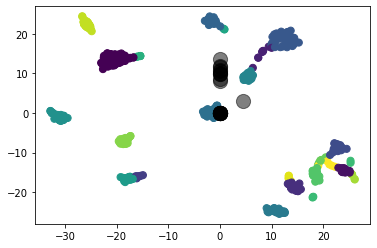

best number of clusters is:  15


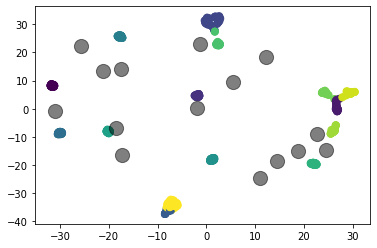

In [21]:
classify_KMeans(complete_df)

# function to plot

In [22]:
def plot_data(symptoms_df, complete_df):

  for index, row in symptoms_df.iterrows():
    region = symptoms_df.open_covid_region_code[index]
    region_df = complete_df.loc[complete_df['open_covid_region_code'] == region]
    region_df = region_df.reset_index(drop = True)
    n_bins = len(region_df)
    X = np.zeros([4, n_bins])
    f, ax = plt.subplots(1, 1)
    for i in range(4):
      # the symptom is actually offset by 1 in the column because of the first column, region code
      # check for each symptom out of top 4 symptom searched
      symptom = row.iloc[i + 1]
      j = 0
      for j, region_row in region_df.iterrows():
        X[i, j] = region_row[symptom]
      sns.regplot(list(range(0, n_bins)),X[i], lowess=True, label=symptom).set_title(region)
    ax.legend()
    plt.show()


# Plot the data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From

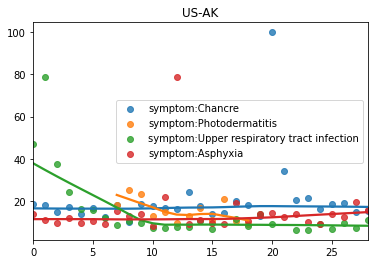

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

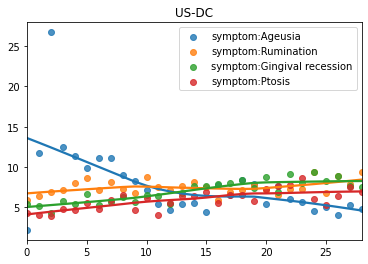

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

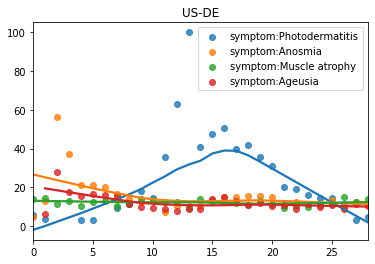

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

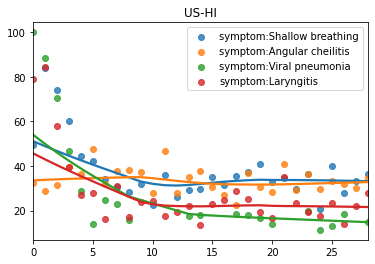

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


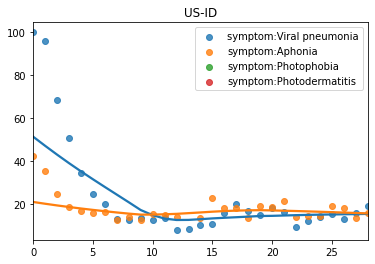

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


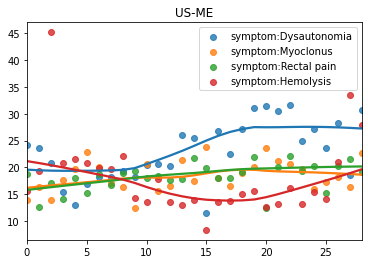

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

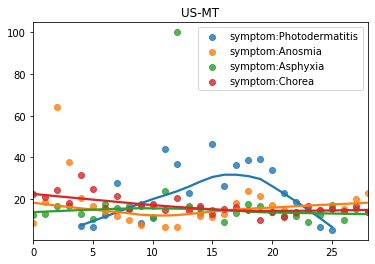

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

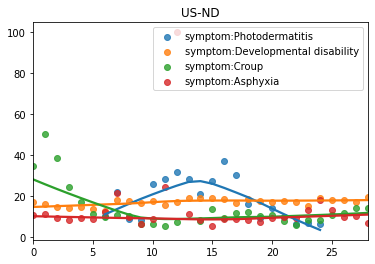

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


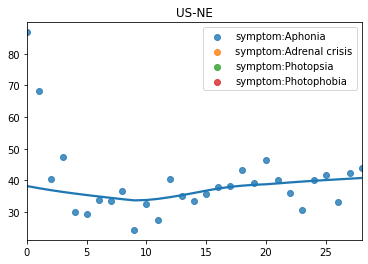

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


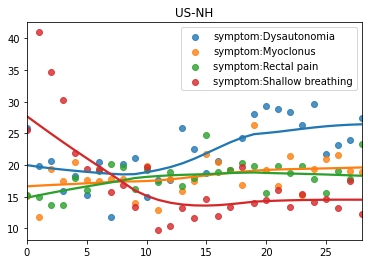

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


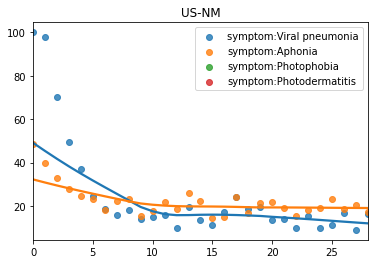

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


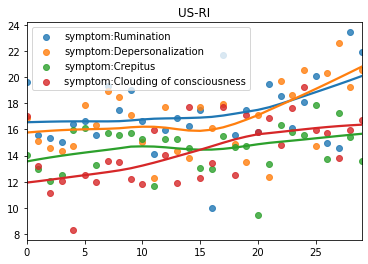

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

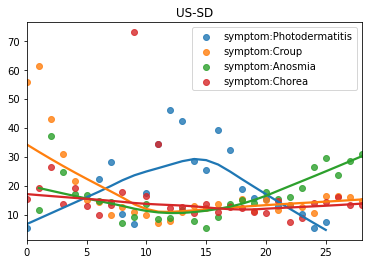

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

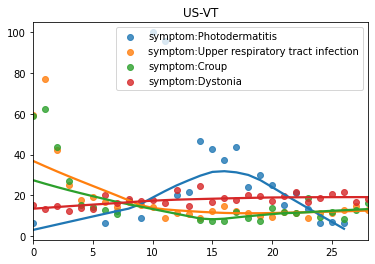

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

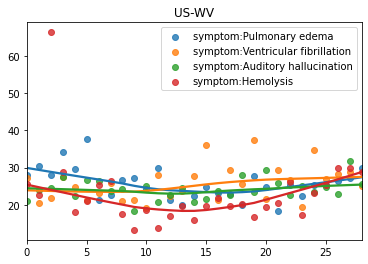

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

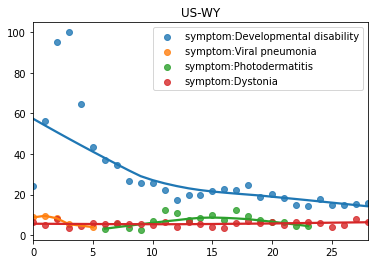

In [23]:
plot_data(only_symptoms_df,complete_df)

In [29]:
def knn_classifier(complete_df, split_type):
  
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new','region_name'], axis = 1)
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new','region_name'], axis = 1)
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']


    # k = 10
    # neighbhoor = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
    # Pred_y = neighbhoor.predict(X_test)
    # print("Accuracy of model at K=4 is",metrics.accuracy_score(Y_test, Pred_y))
    error_rate = []
    for i in range(1,41):
      if i % 2 == 0:
        continue
      knn = KNeighborsRegressor(n_neighbors=i)
      knn.fit(X_train,Y_train)
      pred_i = knn.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title('By Region')
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))


[array(['US-AK', 'US-DC', 'US-DE', 'US-HI'], dtype=object), array(['US-ID', 'US-ME', 'US-MT'], dtype=object), array(['US-ND', 'US-NE', 'US-NH'], dtype=object), array(['US-NM', 'US-RI', 'US-SD'], dtype=object), array(['US-VT', 'US-WV', 'US-WY'], dtype=object)]
Minimum error:  61.58035656085002 at K = 11
Minimum error:  45.65839080459771 at K = 2
Minimum error:  21.207600281491906 at K = 3
Minimum error:  1399.405616078136 at K = 5
Minimum error:  324.24303430138974 at K = 19


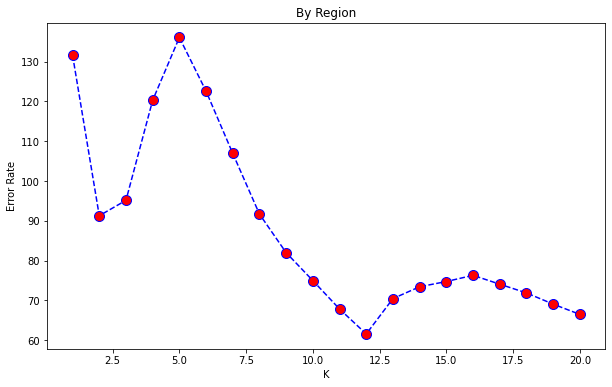

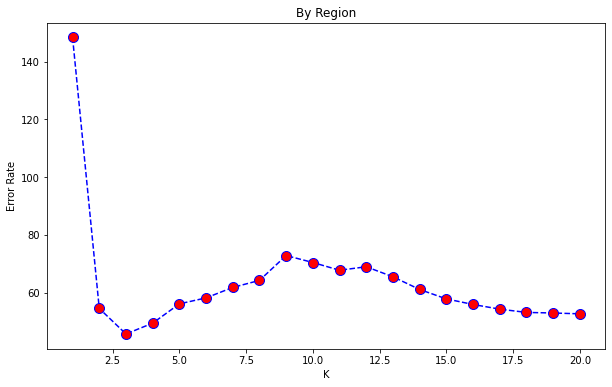

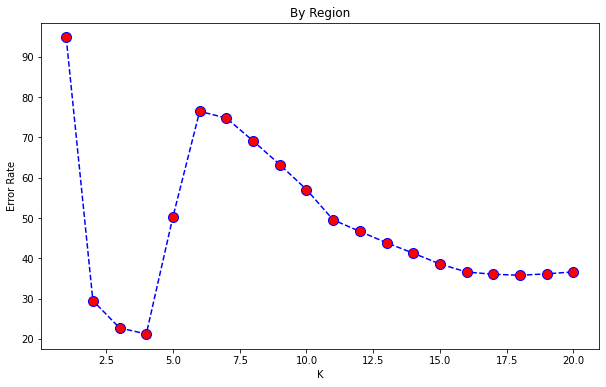

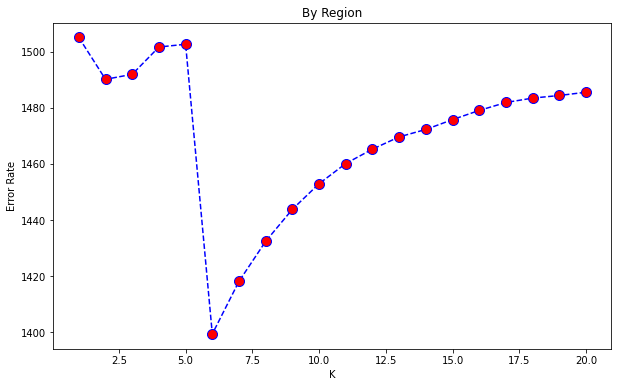

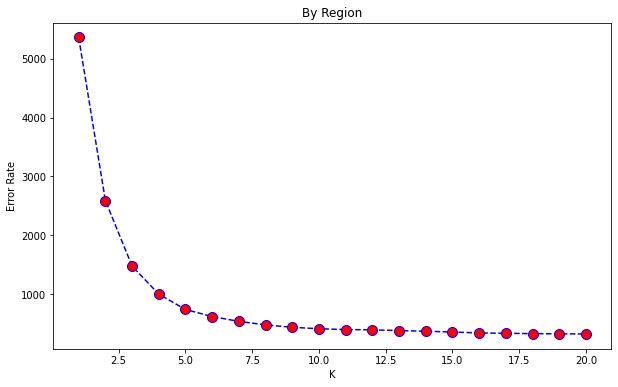

In [30]:
knn_classifier(complete_df, 'region')

[array(['2020-03-09T00:00:00.000000000', '2020-03-16T00:00:00.000000000',
       '2020-03-23T00:00:00.000000000', '2020-03-30T00:00:00.000000000',
       '2020-04-06T00:00:00.000000000', '2020-04-13T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-04-20T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-05-04T00:00:00.000000000', '2020-05-11T00:00:00.000000000',
       '2020-05-18T00:00:00.000000000', '2020-05-25T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-06-01T00:00:00.000000000', '2020-06-08T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000', '2020-06-22T00:00:00.000000000',
       '2020-06-29T00:00:00.000000000', '2020-07-06T00:00:00.000000000'],
      dtype='datetime64[ns]'), array(['2020-07-13T00:00:00.000000000', '2020-07-20T00:00:00.000000000',
       '2020-07-27T00:00:00.000000000', '2020-08-03T00:00:00.000000000',
       '2020-08-10T00:00:00.000000000', '2020-08-17T00:00:00.000000000'],
      dtype='datetime64[ns

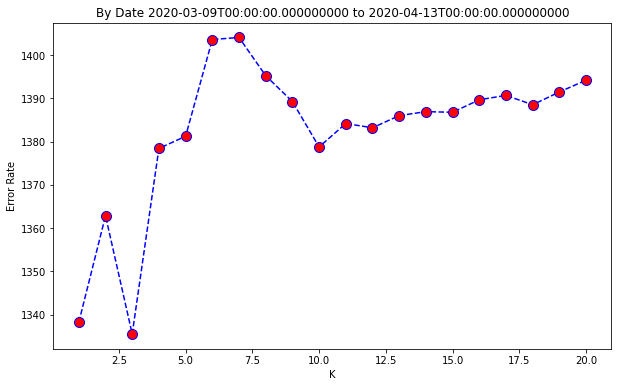

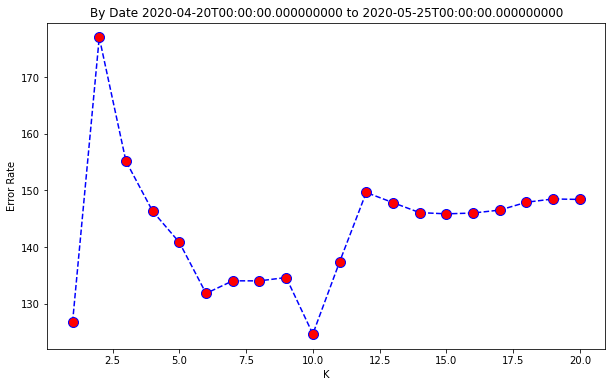

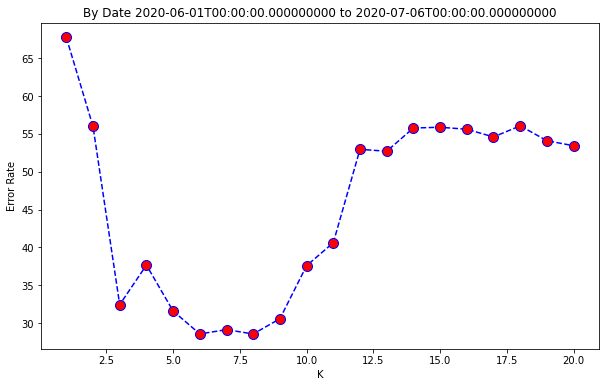

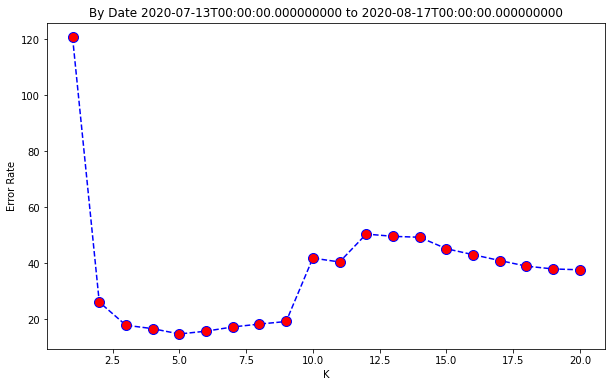

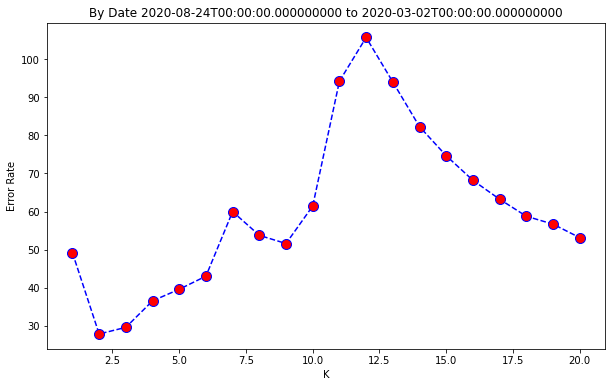

In [31]:
knn_classifier(complete_df, 'time')

In [32]:
def decisionTree_regressor(complete_df, split_type):
    
  complete_df = complete_df.reset_index(drop = True)
  complete_df = complete_df.fillna(0)

  if split_type == 'region':
    splitted = complete_df.open_covid_region_code.unique()
    column = 'open_covid_region_code'
  else:
    splitted = complete_df.date.unique()
    column = 'date'

  splitted = np.array_split(np.array(splitted),5)
  print(splitted)
  for test_list in splitted:

    # there are 5 cv for 20-80 split
    train = complete_df[~complete_df[column].isin(test_list)]
    test = complete_df[complete_df[column].isin(test_list)]

    X_train = train.drop(train.iloc[:, :9], axis = 1)
    X_train = X_train.drop(['hospitalized_new','region_name'], axis = 1)
    # X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))

    print(test[column].unique())
    print(train[column].unique())
    X_test = test.drop(test.iloc[:, :9], axis = 1)
    X_test = X_test.drop(['hospitalized_new','region_name'], axis = 1)
    # X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))

    Y_train = train['hospitalized_new']

    Y_test = test['hospitalized_new']

    error_rate = []
    for i in range(1,40):
      dt = DecisionTreeRegressor(max_depth = i)
      dt.fit(X_train,Y_train)
      pred_i = dt.predict(X_test)
      error_rate.append(np.mean((pred_i - Y_test)**2))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
            marker='o',markerfacecolor='red', markersize=10)
    if split_type == 'region':
      plt.title(','.join(test_list))
    else:
      plt.title('By Date ' + str(test_list[0]) +  ' to ' + str(test_list[-1]))
    plt.xlabel('Depth')
    plt.ylabel('Error Rate')
    print("Minimum error: ",min(error_rate),"at depth level =",error_rate.index(min(error_rate)))

[array(['US-AK', 'US-DC', 'US-DE', 'US-HI'], dtype=object), array(['US-ID', 'US-ME', 'US-MT'], dtype=object), array(['US-ND', 'US-NE', 'US-NH'], dtype=object), array(['US-NM', 'US-RI', 'US-SD'], dtype=object), array(['US-VT', 'US-WV', 'US-WY'], dtype=object)]
['US-AK' 'US-DC' 'US-DE' 'US-HI']
['US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE' 'US-NH' 'US-NM' 'US-RI' 'US-SD'
 'US-VT' 'US-WV' 'US-WY']
Minimum error:  11.962060009313053 at depth level = 1
['US-ID' 'US-ME' 'US-MT']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ND' 'US-NE' 'US-NH' 'US-NM' 'US-RI'
 'US-SD' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  41.44699639125951 at depth level = 0
['US-ND' 'US-NE' 'US-NH']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-NM' 'US-RI'
 'US-SD' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  7.516557769095676 at depth level = 1
['US-NM' 'US-RI' 'US-SD']
['US-AK' 'US-DC' 'US-DE' 'US-HI' 'US-ID' 'US-ME' 'US-MT' 'US-ND' 'US-NE'
 'US-NH' 'US-VT' 'US-WV' 'US-WY']
Minimum error:  1484.8608026122906 at depth leve

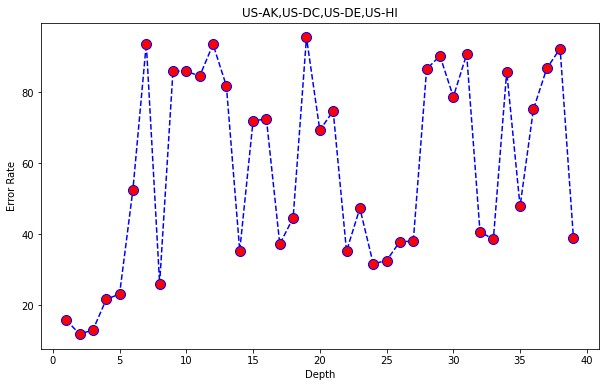

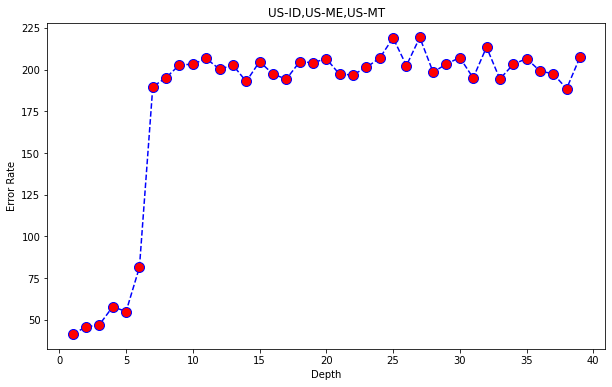

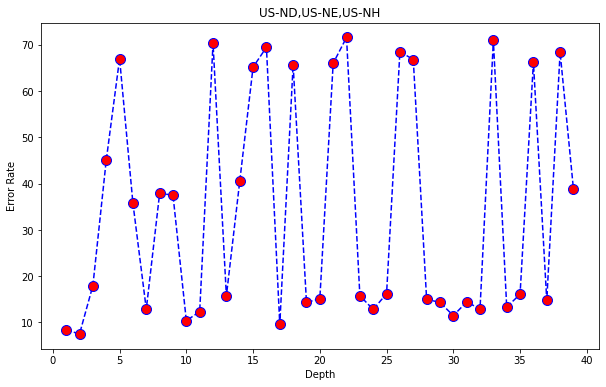

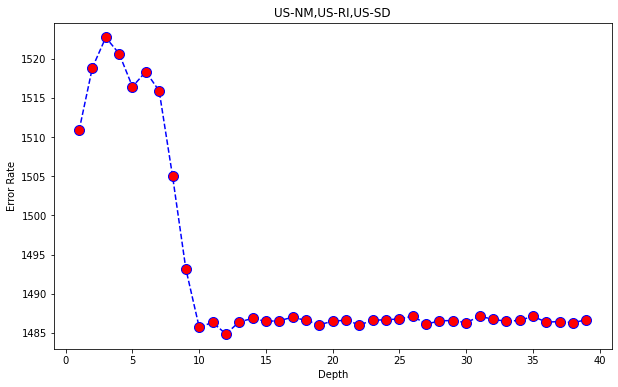

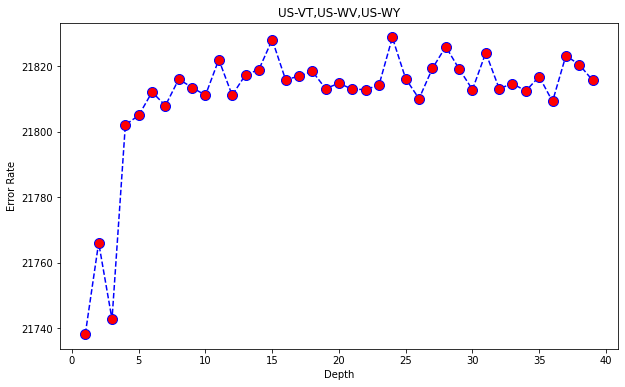

In [33]:
decisionTree_regressor(complete_df, 'region')